In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

In [2]:
def get_label(J, N, M, i, j):
    moves = np.array([[1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [1, -1], [-1, 1], [-1, -1]])
    lab = -1

    for m in range(8):
        x, y = i + moves[m, 0], j + moves[m, 1]

        if x == N or y == M: # If x or y goes beyond the maximum size of the image
            continue
        if 1 <= x <= N and 1 <= y <= M and J[x, y] > 0:
            if lab == -1:
                lab = J[x, y]
            else:
                lab = min(J[x, y], lab)

    return lab


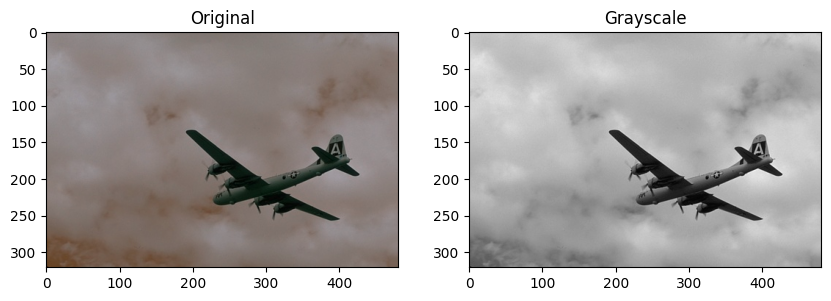

In [3]:
#  Reading input
Im = cv2.imread('../raw/image.jpg')
N, M, T = Im.shape

# Initialization
Im1 = cv2.cvtColor(Im, cv2.COLOR_BGR2GRAY).astype(np.float64)

# create two 2 columns 1 row axis
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].set_title('Original')
ax[0].imshow(Im)
ax[1].set_title('Grayscale')
ax[1].imshow(Im1, cmap='gray')
plt.show()

minI = np.min(Im1)
maxI = np.max(Im1)
J = np.zeros((N, M), dtype=np.int32)

curr_label = 1


### Watershed Algorithm Implementation

In [4]:
for i in range(int(minI), int(maxI) + 1):
    idx, idy = np.where(Im1 == i) # Returns the indices x and y of the elements 
    pts = len(idx)

    if pts == 0:
        continue

    for j in range(pts):
        lab = get_label(J, N, M, idx[j], idy[j])

        if lab == -1:
            J[idx[j], idy[j]] = curr_label
            curr_label += 1
        else:
            J[idx[j], idy[j]] = lab

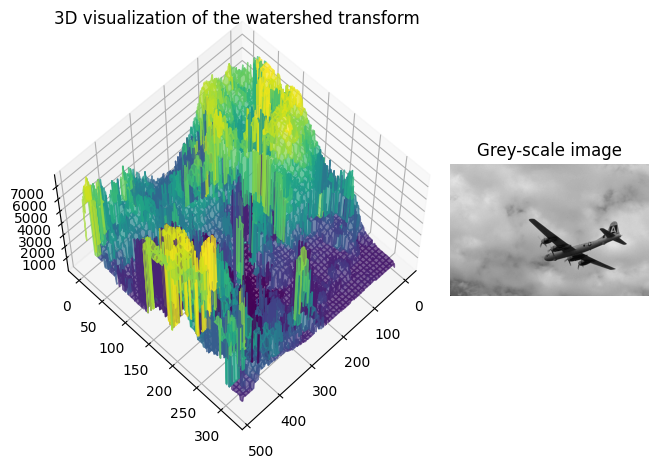

In [5]:
# Plot the 3D surface
gs = GridSpec(1, 2, width_ratios=[2, 1])
fig3 = plt.figure()

X, Y = np.meshgrid(np.arange(J.shape[1]), np.arange(J.shape[0]))

ax_3d = fig3.add_subplot(gs[0], projection='3d')
cmap = plt.get_cmap('viridis')
ax_3d.plot_surface(X, Y, J, cmap=cmap, facecolors=cmap(J / J.max()), alpha = 0.7)
ax_3d.view_init(elev=60, azim=45)
ax_3d.set_title('3D visualization of the watershed transform')

ax_2d = fig3.add_subplot(gs[1])
ax_2d.imshow(Im1, cmap='gray')
ax_2d.set_title('Grey-scale image')
ax_2d.axis('off')

plt.tight_layout()

In [6]:
def find_concentration_range_2d(input_array, concentration):
    flattened_array = input_array.flatten()
    sorted_array = np.sort(flattened_array)
    cumulative_sum = np.cumsum(sorted_array, dtype=np.int64)
    total_sum = cumulative_sum[-1]
    threshold = concentration * total_sum
    concentration_index = np.argmax(cumulative_sum >= threshold)
    concentration_range = sorted_array[:concentration_index + 1]
    return concentration_range[0], concentration_range[-1]

### Obtaining Segmented Image

Text(0, 0.5, 'Frequency')

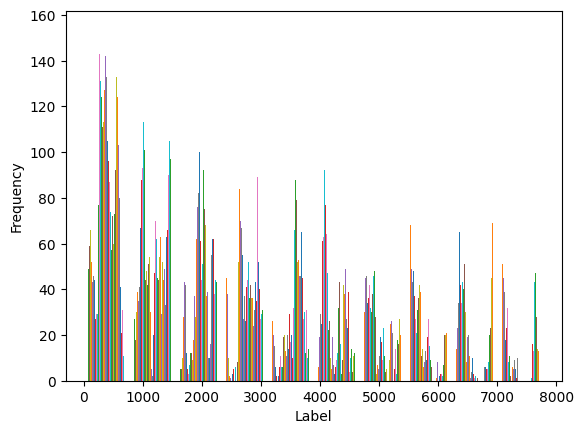

In [7]:
plt.figure()
plt.hist(J)
plt.xlabel('Label')
plt.ylabel('Frequency')

In [8]:
Final_im = np.zeros_like(Im)

_, max_concentration = find_concentration_range_2d(J, 0.01) #1 percent of the concentration

for i in range(N):
    for j in range(M):
        if J[i, j] < max_concentration:
            Final_im[i, j, 1] = 255
        else:
            Final_im[i, j, 2] = 0

### Display Results

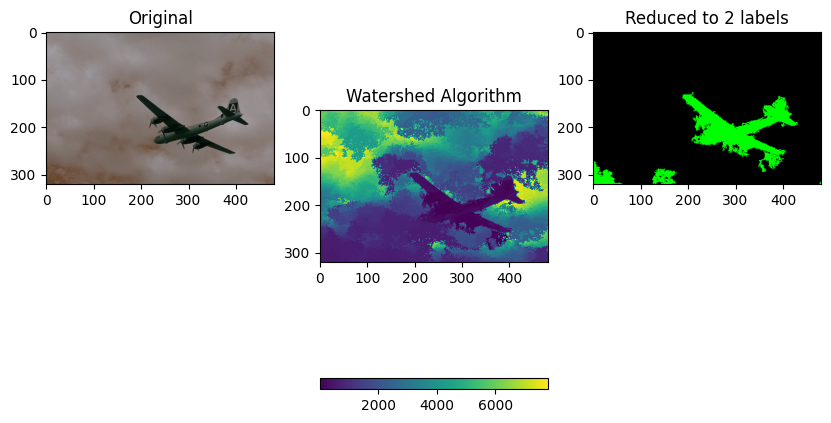

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(Im)
ax[0].set_title('Original')
ax[1].set_title('Watershed Algorithm')
ax[1].imshow(J)
fig.colorbar(ax[1].imshow(J), ax=ax[1],orientation='horizontal')
ax[2].set_title('Reduced to 2 labels')
ax[2].imshow(Final_im)

In [10]:
# Save file
cv2.imwrite('../final/watershed_transformed.jpg', Final_im)

True